# Flight Delay Analysis - Random Forest Model Training

## Phase 4: Building and Evaluating Random Forest Models

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import Random Forest model functions
from src.models.random_forest import (
    load_engineered_data,
    prepare_data_for_modeling,
    train_random_forest_regressor,
    train_random_forest_classifier,
    evaluate_regressor,
    evaluate_classifier,
    get_feature_importance,
    save_model,
    load_model,
    train_and_evaluate_regressor
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
# Reload external files
%load_ext autoreload
%autoreload 2

---
## Part 1: Load Engineered Data
---

In [3]:
# Load the engineered dataset
input_path = '../data/processed/flight_delays_engineered.csv'
df = load_engineered_data(input_path)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1527160, 19)

First few rows:


,Date (YYYY-MM-DD),Scheduled Elapsed Time (Minutes),IsWeekend,Is_Holiday_Period,Carrier_9E,Carrier_AA,Carrier_AS,Carrier_DL,Carrier_EV,Carrier_MQ,Carrier_NK,Carrier_OO,Carrier_UA,Carrier_WN,Carrier_YX,Origin_Airport_Encoded,Season_Encoded,Arrival Delay (Minutes),Is_Delayed
0,2019-01-01,83,0,1,1,0,0,0,0,0,0,0,0,0,0,67,3,-1,0
1,2019-01-01,72,0,1,1,0,0,0,0,0,0,0,0,0,0,163,3,-14,0
2,2019-01-01,85,0,1,1,0,0,0,0,0,0,0,0,0,0,86,3,9,0
3,2019-01-01,112,0,1,1,0,0,0,0,0,0,0,0,0,0,16,3,-7,0
4,2019-01-01,129,0,1,1,0,0,0,0,0,0,0,0,0,0,28,3,-32,0


In [4]:
# Define features for modeling
# Exclude non-predictive columns and the target variables
exclude_cols = ['Date (YYYY-MM-DD)', 'Carrier Code', 'Origin Airport', 
                'Season', 'Arrival Delay (Minutes)', 'Is_Delayed']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal features for modeling: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")


Total features for modeling: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded


CLASS DISTRIBUTION ANALYSIS:

Is_Delayed Distribution:
  Class 0 (On-time):  1,294,299 (84.75%)
  Class 1 (Delayed):  232,861 (15.25%)
  Imbalance ratio: 5.56:1


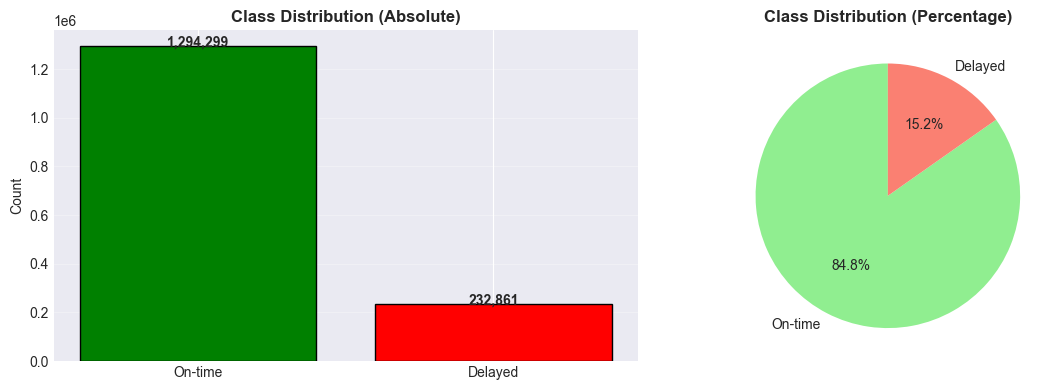

In [5]:
print("CLASS DISTRIBUTION ANALYSIS:")

# For classification
delayed_counts = df['Is_Delayed'].value_counts()
delayed_pct = df['Is_Delayed'].value_counts(normalize=True) * 100

print("\nIs_Delayed Distribution:")
print(f"  Class 0 (On-time):  {delayed_counts[0]:,} ({delayed_pct[0]:.2f}%)")
print(f"  Class 1 (Delayed):  {delayed_counts[1]:,} ({delayed_pct[1]:.2f}%)")
print(f"  Imbalance ratio: {delayed_counts[0] / delayed_counts[1]:.2f}:1")

# Visualize
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
axes[0].bar(['On-time', 'Delayed'], delayed_counts.values, color=['green', 'red'], edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute)', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(delayed_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(delayed_counts.values, labels=['On-time', 'Delayed'], autopct='%1.1f%%', 
            colors=['lightgreen', 'salmon'], startangle=90)
axes[1].set_title('Class Distribution (Percentage)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

---
## Part 2: Classification Task - Predicting Delay vs On-time
---

### 2.1 Prepare Data for Classification

In [6]:
# Target: Is_Delayed (binary: 0=on-time, 1=delayed)
target_classification = 'Is_Delayed'

X_train_clf, X_test_clf, y_train_clf, y_test_clf = prepare_data_for_modeling(
    df=df,
    feature_cols=feature_cols,
    target_col=target_classification,
    test_size=0.2,
    random_state=42
)

print(f"\nTarget distribution (training set):")
print(y_train_clf.value_counts())
print(f"\nClass balance:")
print(y_train_clf.value_counts(normalize=True))

  Training set: 1,221,728 samples
  Test set: 305,432 samples
  Feature dimensions: 16

Target distribution (training set):
Is_Delayed
0    1035253
1     186475
Name: count, dtype: int64

Class balance:
Is_Delayed
0    0.847368
1    0.152632
Name: proportion, dtype: float64


### 2.2a Train Random Forest Classifier (Without Class Imbalance)

In [7]:
# Train the model
rf_classifier = train_random_forest_classifier(
    X_train=X_train_clf,
    y_train=y_train_clf,
    n_estimators=50,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

TRAINING RANDOM FOREST CLASSIFIER

Model parameters:
  - n_estimators: 50
  - max_depth: 20
  - min_samples_split: 20
  - min_samples_leaf: 10
  - class_weight: None
  - random_state: 42
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s


building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50

✓ Training complete in 7.97 seconds


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.8s finished


### 2.2b Train Balanced Random Forest Classifier (with class_weight)

In [8]:
# With class imbalance
rf_classifier_balanced = train_random_forest_classifier(
    X_train=X_train_clf,
    y_train=y_train_clf,
    n_estimators=50,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1,
    verbose=0
)

TRAINING RANDOM FOREST CLASSIFIER

Model parameters:
  - n_estimators: 50
  - max_depth: 20
  - min_samples_split: 20
  - min_samples_leaf: 10
  - class_weight: balanced
  - random_state: 42

✓ Training complete in 8.38 seconds

✓ Training complete in 8.38 seconds


### 2.2c Hyperparameter Tuning (RandomizedSearchCV)
A lightweight parameter search to find better Random Forest settings (optimizing F1).

In [ ]:
# Trying hyperparameter tuning using RandomizedSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# param_distributions = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10, 20],
#     'min_samples_leaf': [1, 2, 4, 10],
#     'max_features': ['sqrt', 'log2', None],
#     'class_weight': [None, 'balanced']
# }

# base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
# search = RandomizedSearchCV(
#     estimator=base_model,
#     param_distributions=param_distributions,
#     n_iter=20,
#     scoring='f1',
#     n_jobs=-1,
#     cv=3,
#     verbose=2,
#     random_state=42
# )

# print("HYPERPARAMETER TUNING: RandomizedSearchCV (F1 scoring)")
# search.fit(X_train_clf, y_train_clf)
# print("Best params:", search.best_params_)
# print(f"Best CV F1: {search.best_score_:.4f}")

# rf_classifier_tuned = search.best_estimator_

# Evaluate tuned model
# clf_metrics_tuned = evaluate_classifier(
#     model=rf_classifier_tuned,
#     X_train=X_train_clf,
#     y_train=y_train_clf,
#     X_test=X_test_clf,
#     y_test=y_test_clf
# )


HYPERPARAMETER TUNING: RandomizedSearchCV (F1 scoring)
Best params: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
Best CV F1: 0.3113

CLASSIFICATION MODEL EVALUATION
Best params: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}
Best CV F1: 0.3113

CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.6564
  Precision: 0.2504
  Recall:    0.6278
  F1-Score:  0.3580

Test Set Performance:
  Accuracy:  0.6326
  Precision: 0.2184
  Recall:    0.5502
  F1-Score:  0.3126
  ROC-AUC:   0.6367

Confusion Matrix (Test Set):
[[167693  91353]
 [ 20865  25521]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.89      0.65      0.75    259046
     Delayed       0.22      0.55      0.31     46386

    accuracy                           0.6

In [10]:
# With class imbalance
rf_classifier_tuned = train_random_forest_classifier(
    X_train=X_train_clf,
    y_train=y_train_clf,
    n_estimators=200,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=4,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1,
    verbose=2
)

TRAINING RANDOM FOREST CLASSIFIER

Model parameters:
  - n_estimators: 200
  - max_depth: 20
  - min_samples_split: 20
  - min_samples_leaf: 4
  - class_weight: balanced
  - random_state: 42


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
bu

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s


building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.3s


building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 163 of 200
building tree 164 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 171 of 200
building tree 172 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 175 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   32.5s finished


### 2.3 Evaluate Classifier Performance

In [11]:
# Evaluate the model
clf_metrics = evaluate_classifier(
    model=rf_classifier,
    X_train=X_train_clf,
    y_train=y_train_clf,
    X_test=X_test_clf,
    y_test=y_test_clf
)

CLASSIFICATION MODEL EVALUATION


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished



Training Set Performance:
  Accuracy:  0.8479
  Precision: 0.6106
  Recall:    0.0098
  F1-Score:  0.0194

Test Set Performance:
  Accuracy:  0.8480
  Precision: 0.4623
  Recall:    0.0071
  F1-Score:  0.0141
  ROC-AUC:   0.6386

Confusion Matrix (Test Set):
[[258661    385]
 [ 46055    331]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.85      1.00      0.92    259046
     Delayed       0.46      0.01      0.01     46386

    accuracy                           0.85    305432
   macro avg       0.66      0.50      0.47    305432
weighted avg       0.79      0.85      0.78    305432



In [ ]:
# Evaluate the balanced model
clf_metrics_balanced = evaluate_classifier(
    model=rf_classifier_balanced,
    X_train=X_train_clf,
    y_train=y_train_clf,
    X_test=X_test_clf,
    y_test=y_test_clf
)

CLASSIFICATION MODEL EVALUATION

Training Set Performance:
  Accuracy:  0.6504
  Precision: 0.2462
  Recall:    0.6257
  F1-Score:  0.3534

Test Set Performance:
  Accuracy:  0.6288
  Precision: 0.2177
  Recall:    0.5569
  F1-Score:  0.3131
  ROC-AUC:   0.6382

Confusion Matrix (Test Set):
[[166237  92809]
 [ 20555  25831]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.89      0.64      0.75    259046
     Delayed       0.22      0.56      0.31     46386

    accuracy                           0.63    305432
   macro avg       0.55      0.60      0.53    305432
weighted avg       0.79      0.63      0.68    305432


Training Set Performance:
  Accuracy:  0.6504
  Precision: 0.2462
  Recall:    0.6257
  F1-Score:  0.3534

Test Set Performance:
  Accuracy:  0.6288
  Precision: 0.2177
  Recall:    0.5569
  F1-Score:  0.3131
  ROC-AUC:   0.6382

Confusion Matrix (Test Set):
[[166237  92809]
 [ 20555  25831]]

Classification 

In [13]:
# Evaluate tuned model
clf_metrics_tuned = evaluate_classifier(
    model=rf_classifier_tuned,
    X_train=X_train_clf,
    y_train=y_train_clf,
    X_test=X_test_clf,
    y_test=y_test_clf
)

CLASSIFICATION MODEL EVALUATION


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    8.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 co


Training Set Performance:
  Accuracy:  0.6564
  Precision: 0.2504
  Recall:    0.6278
  F1-Score:  0.3580

Test Set Performance:
  Accuracy:  0.6326
  Precision: 0.2184
  Recall:    0.5502
  F1-Score:  0.3126
  ROC-AUC:   0.6367

Confusion Matrix (Test Set):
[[167693  91353]
 [ 20865  25521]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     On-time       0.89      0.65      0.75    259046
     Delayed       0.22      0.55      0.31     46386

    accuracy                           0.63    305432
   macro avg       0.55      0.60      0.53    305432
weighted avg       0.79      0.63      0.68    305432



In [ ]:
# Compare with original model
print("MODEL COMPARISON: Original vs Balanced (+ Tuned if available)")

metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
original_vals = [
    f"{clf_metrics['test_accuracy']:.4f}",
    f"{clf_metrics['test_precision']:.4f}",
    f"{clf_metrics['test_recall']:.4f}",
    f"{clf_metrics['test_f1']:.4f}",
    f"{clf_metrics['test_roc_auc']:.4f}"
]
balanced_vals = [
    f"{clf_metrics_balanced['test_accuracy']:.4f}",
    f"{clf_metrics_balanced['test_precision']:.4f}",
    f"{clf_metrics_balanced['test_recall']:.4f}",
    f"{clf_metrics_balanced['test_f1']:.4f}",
    f"{clf_metrics_balanced['test_roc_auc']:.4f}"
]

# Optionally include tuned model if present
try:
    tuned_vals = [
        f"{clf_metrics_tuned['test_accuracy']:.4f}",
        f"{clf_metrics_tuned['test_precision']:.4f}",
        f"{clf_metrics_tuned['test_recall']:.4f}",
        f"{clf_metrics_tuned['test_f1']:.4f}",
        f"{clf_metrics_tuned['test_roc_auc']:.4f}"
    ]
    data = {
        'Metric': metrics_labels,
        'Original Model': original_vals,
        'Balanced Model': balanced_vals,
        'Tuned Model': tuned_vals,
    }
except NameError:
    data = {
        'Metric': metrics_labels,
        'Original Model': original_vals,
        'Balanced Model': balanced_vals,
    }

comparison_df = pd.DataFrame(data)
print("\n")
print(comparison_df.to_string(index=False))

print("\nKey Insights:")
print("  - Balanced model should have HIGHER recall (catches more delays)")
print("  - May have slightly LOWER precision (more false alarms)")
print("  - Tuned model aims to improve overall F1 (and ROC-AUC) with a small search")

MODEL COMPARISON: Original vs Balanced (+ Tuned if available)


   Metric Original Model Balanced Model Tuned Model
 Accuracy         0.8480         0.6288      0.6326
Precision         0.4623         0.2177      0.2184
   Recall         0.0071         0.5569      0.5502
 F1-Score         0.0141         0.3131      0.3126
  ROC-AUC         0.6386         0.6382      0.6367

Key Insights:
  - Balanced model should have HIGHER recall (catches more delays)
  - May have slightly LOWER precision (more false alarms)
  - Tuned model aims to improve overall F1 (and ROC-AUC) with a small search


### 2.4 Feature Importance (Classification)

In [15]:
# Get feature importance
importance_df_clf = get_feature_importance(
    model=rf_classifier,
    feature_names=feature_cols,
    top_n=20
)

TOP 20 FEATURE IMPORTANCES
                         Feature  Importance
Scheduled Elapsed Time (Minutes)    0.460496
          Origin_Airport_Encoded    0.248575
                  Season_Encoded    0.139115
                      Carrier_DL    0.043914
                      Carrier_NK    0.021020
               Is_Holiday_Period    0.020475
                       IsWeekend    0.019823
                      Carrier_AA    0.017553
                      Carrier_9E    0.010819
                      Carrier_WN    0.006911
                      Carrier_UA    0.004187
                      Carrier_OO    0.003855
                      Carrier_YX    0.001717
                      Carrier_AS    0.000838
                      Carrier_MQ    0.000542
                      Carrier_EV    0.000158


### 2.5 Visualize Classification Results

In [19]:
# Create visualizations
from sklearn.metrics import roc_curve, auc

### Plot Imbalanced 

Saved visualization to: ../results/figures/rf_imbalanced_classification_results.png


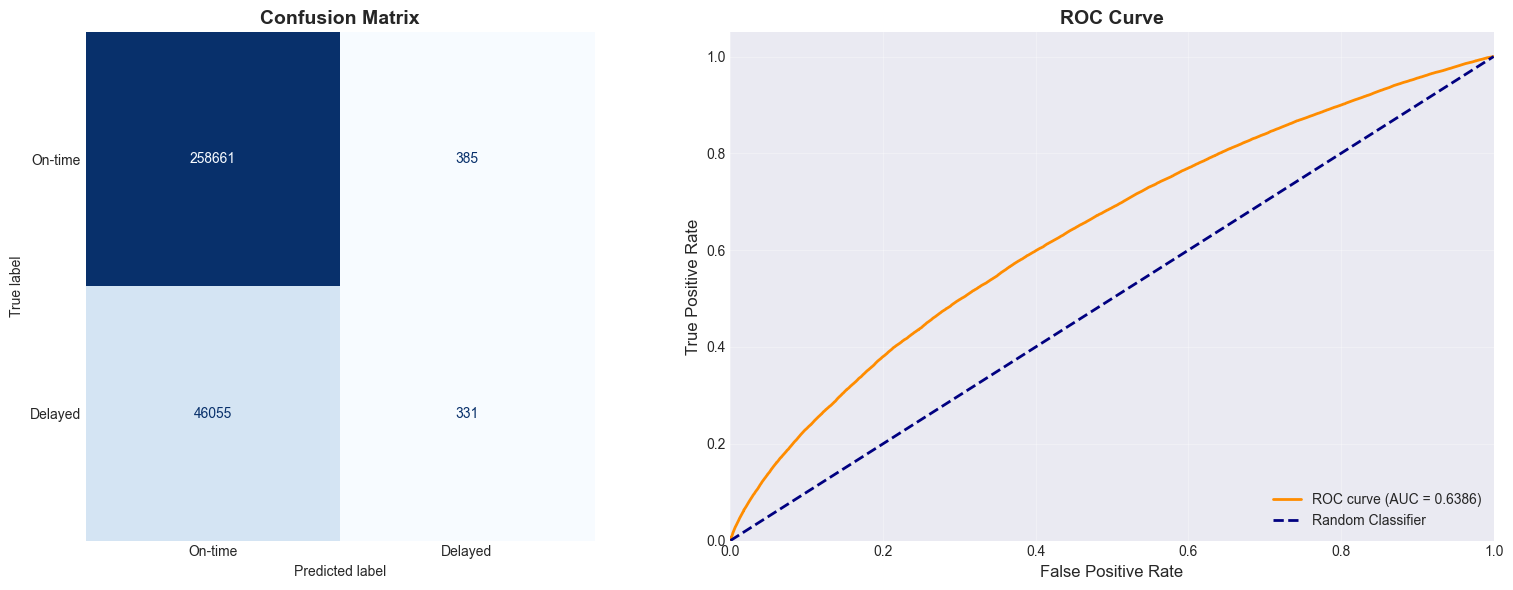

In [31]:
# Create 1 row × 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confusion Matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=clf_metrics['confusion_matrix'],
    display_labels=['On-time', 'Delayed']
)
cm_display.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].grid(False)

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_clf, clf_metrics['y_test_proba'])
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Ensure save directory exists and save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_tuned_classification_results.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/rf_imbalanced_classification_results.png")
plt.show()

Saved visualization to: ../results/figures/rf_imbalanced_predicted_probability_distribution.png


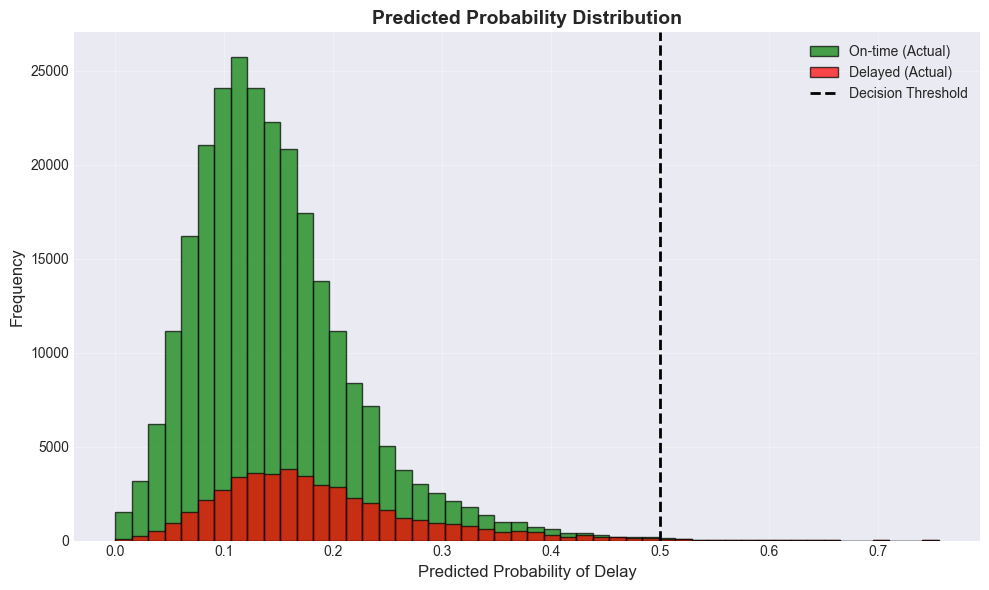

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Prediction Probability Distribution
# Predicted Probability Distribution
ax.hist(
    clf_metrics['y_test_proba'][y_test_clf == 0],
    bins=50, alpha=0.7, label='On-time (Actual)',
    color='green', edgecolor='black'
)
ax.hist(
    clf_metrics['y_test_proba'][y_test_clf == 1],
    bins=50, alpha=0.7, label='Delayed (Actual)',
    color='red', edgecolor='black'
)
ax.axvline(x=0.5, color='black', linestyle='--', lw=2, label='Decision Threshold')

# Labels and formatting
ax.set_xlabel('Predicted Probability of Delay', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Predicted Probability Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_predicted_probability_distribution.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/rf_imbalanced_predicted_probability_distribution.png")

plt.show()

### Plot Tuned

Saved visualization to: ../results/figures/rf_tuned_classification_results.png


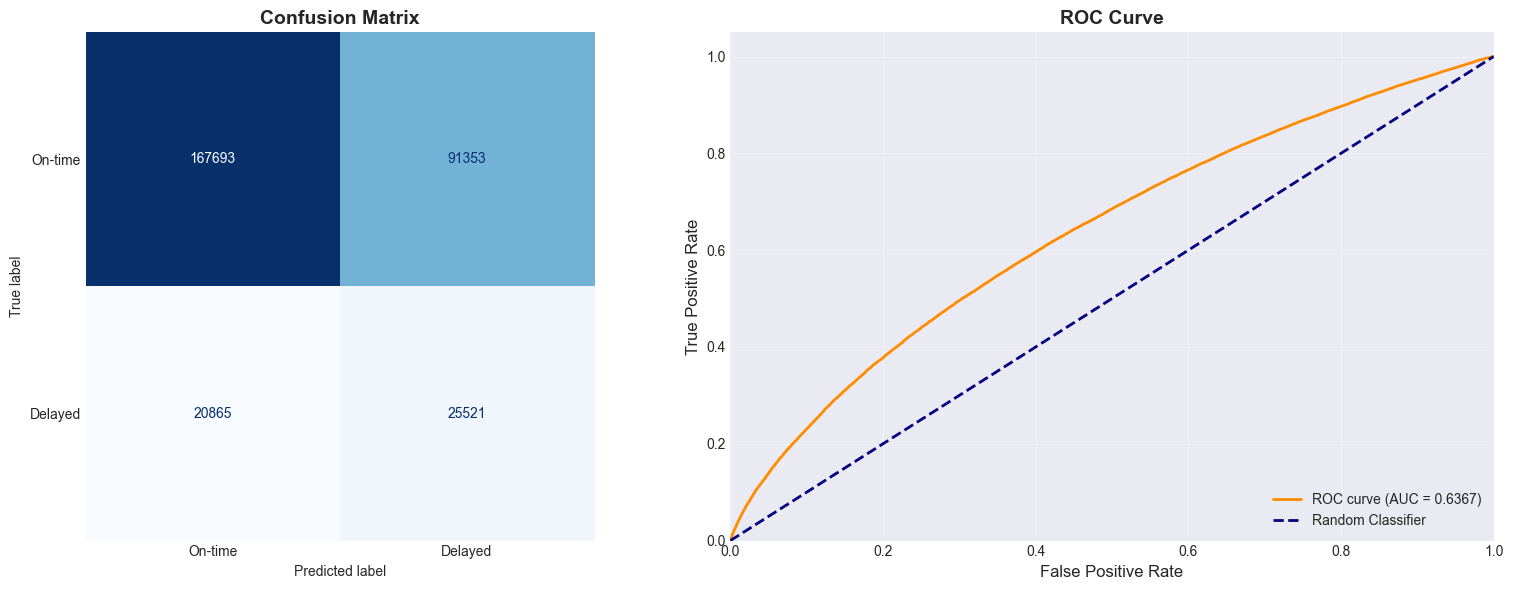

In [39]:
# Create 1 row × 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Confusion Matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=clf_metrics_tuned['confusion_matrix'],
    display_labels=['On-time', 'Delayed']
)
cm_display.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].grid(False)

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test_clf, clf_metrics_tuned['y_test_proba'])
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Ensure save directory exists and save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_tuned_classification_results.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/rf_tuned_classification_results.png")
plt.show()

Saved visualization to: ../results/figures/rf_tuned_predicted_probability_distribution.png


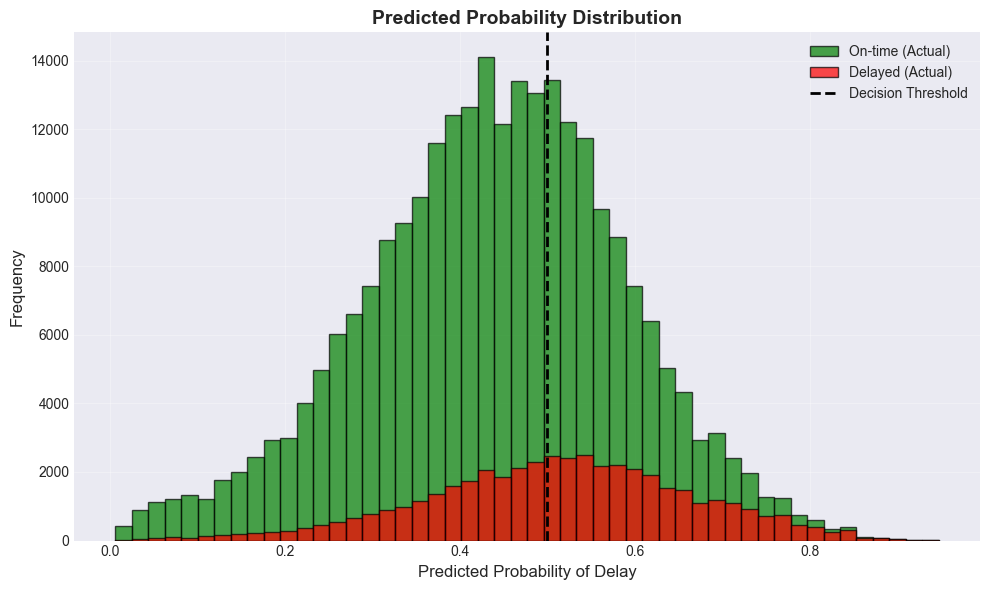

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

# 3. Prediction Probability Distribution
# Predicted Probability Distribution
ax.hist(
    clf_metrics_tuned['y_test_proba'][y_test_clf == 0],
    bins=50, alpha=0.7, label='On-time (Actual)',
    color='green', edgecolor='black'
)
ax.hist(
    clf_metrics_tuned['y_test_proba'][y_test_clf == 1],
    bins=50, alpha=0.7, label='Delayed (Actual)',
    color='red', edgecolor='black'
)
ax.axvline(x=0.5, color='black', linestyle='--', lw=2, label='Decision Threshold')

# Labels and formatting
ax.set_xlabel('Predicted Probability of Delay', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Predicted Probability Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_predicted_probability_distribution.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/rf_tuned_predicted_probability_distribution.png")

plt.show()

## Feature Importance

Saved visualization to: ../results/figures/rf_top15_feature_importances.png


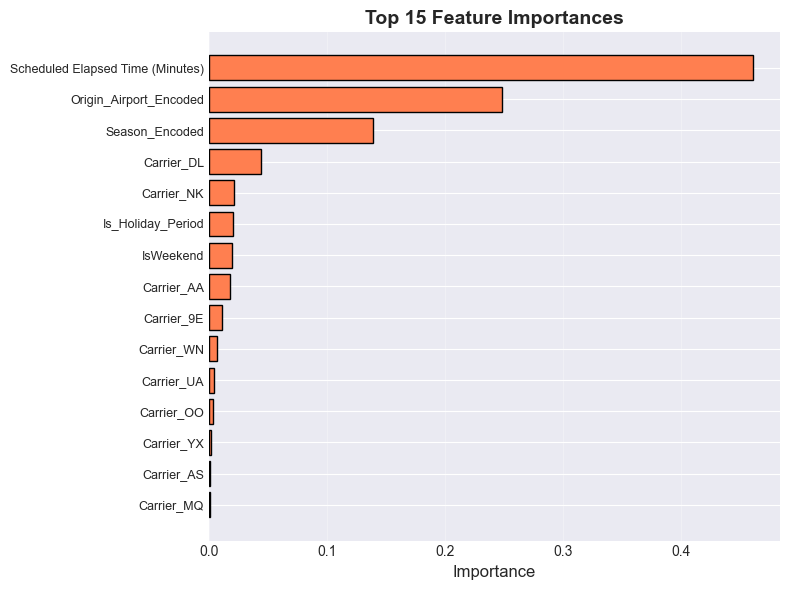

In [34]:
# Select top 15 important features
top_features_clf = importance_df_clf.head(15)

# Create a single figure
fig, ax = plt.subplots(figsize=(8, 6))

# Horizontal bar chart
ax.barh(
    range(len(top_features_clf)),
    top_features_clf['Importance'],
    color='coral',
    edgecolor='black'
)
ax.set_yticks(range(len(top_features_clf)))
ax.set_yticklabels(top_features_clf['Feature'], fontsize=9)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()  # Highest importance at top

plt.tight_layout()

# Save figure
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_top15_feature_importances.png', dpi=300, bbox_inches='tight')
print("Saved visualization to: ../results/figures/rf_top15_feature_importances.png")

plt.show()

### 2.6 Save Classification Model

In [ ]:
# Save the best-performing trained model (by F1 on test)
# Fall back order: tuned > balanced > original
best_model = None
best_metrics = None
best_name = None

candidates = []
try:
    candidates.append((rf_classifier_tuned, clf_metrics_tuned, 'rf_classifier_tuned.pkl'))
except NameError:
    pass

candidates.append((rf_classifier_balanced, clf_metrics_balanced, 'rf_classifier_balanced.pkl'))
candidates.append((rf_classifier, clf_metrics, 'rf_classifier.pkl'))

# Pick the model with highest test F1
best_model, best_metrics, best_filename = max(candidates, key=lambda x: x[1]['test_f1'])

model_path = f"../outputs/models/{best_filename}"
save_model(best_model, model_path)
print(f"Saved best model ({best_filename}) with Test F1={best_metrics['test_f1']:.4f}")


 Model saved to: ../outputs/models/rf_classifier_balanced.pkl
✓ Saved best model (rf_classifier_balanced.pkl) with Test F1=0.3131


---
## Part 3: Model Comparison Summary
---

In [ ]:
# Summary comparison
print("MODEL PERFORMANCE SUMMARY (Classification)")

rows = []
rows.append({
    'Model': 'Original RF',
    'Accuracy': clf_metrics['test_accuracy'],
    'Precision': clf_metrics['test_precision'],
    'Recall': clf_metrics['test_recall'],
    'F1': clf_metrics['test_f1'],
    'ROC_AUC': clf_metrics['test_roc_auc']
})
rows.append({
    'Model': 'Balanced RF',
    'Accuracy': clf_metrics_balanced['test_accuracy'],
    'Precision': clf_metrics_balanced['test_precision'],
    'Recall': clf_metrics_balanced['test_recall'],
    'F1': clf_metrics_balanced['test_f1'],
    'ROC_AUC': clf_metrics_balanced['test_roc_auc']
})
try:
    rows.append({
        'Model': 'Tuned RF',
        'Accuracy': clf_metrics_tuned['test_accuracy'],
        'Precision': clf_metrics_tuned['test_precision'],
        'Recall': clf_metrics_tuned['test_recall'],
        'F1': clf_metrics_tuned['test_f1'],
        'ROC_AUC': clf_metrics_tuned['test_roc_auc']
    })
except NameError:
    pass

summary_df = pd.DataFrame(rows)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

print("\nModels evaluated successfully!")


MODEL PERFORMANCE SUMMARY (Classification)
      Model  Accuracy  Precision  Recall     F1  ROC_AUC
Original RF    0.8480     0.4623  0.0071 0.0141   0.6386
Balanced RF    0.6288     0.2177  0.5569 0.3131   0.6382
   Tuned RF    0.6326     0.2184  0.5502 0.3126   0.6367

✓ Models evaluated successfully!


---
## Part 4: Save Results to File
---

In [ ]:
# Save metrics to CSV (Classification models)
rows = []
rows.append({
    'Model': 'Original RF',
    'Task': 'Classification (Delay Detection)',
    'Test_Accuracy': clf_metrics['test_accuracy'],
    'Test_Precision': clf_metrics['test_precision'],
    'Test_Recall': clf_metrics['test_recall'],
    'Test_F1': clf_metrics['test_f1'],
    'Test_ROC_AUC': clf_metrics['test_roc_auc']
})
rows.append({
    'Model': 'Balanced RF',
    'Task': 'Classification (Delay Detection)',
    'Test_Accuracy': clf_metrics_balanced['test_accuracy'],
    'Test_Precision': clf_metrics_balanced['test_precision'],
    'Test_Recall': clf_metrics_balanced['test_recall'],
    'Test_F1': clf_metrics_balanced['test_f1'],
    'Test_ROC_AUC': clf_metrics_balanced['test_roc_auc']
})
try:
    rows.append({
        'Model': 'Tuned RF',
        'Task': 'Classification (Delay Detection)',
        'Test_Accuracy': clf_metrics_tuned['test_accuracy'],
        'Test_Precision': clf_metrics_tuned['test_precision'],
        'Test_Recall': clf_metrics_tuned['test_recall'],
        'Test_F1': clf_metrics_tuned['test_f1'],
        'Test_ROC_AUC': clf_metrics_tuned['test_roc_auc']
    })
except NameError:
    pass

results_summary = pd.DataFrame(rows)

results_dir = Path('../results')
results_dir.mkdir(parents=True, exist_ok=True)
results_summary.to_csv(results_dir / 'model_performance_summary.csv', index=False)

print("Results saved to: ../results/model_performance_summary.csv")
print("\nResults Summary:")
display(results_summary)

✓ Results saved to: ../results/model_performance_summary.csv

Results Summary:


,Model,Task,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
0,Original RF,Classification (Delay Detection),0.847953,0.462291,0.007136,0.014055,0.638628
1,Balanced RF,Classification (Delay Detection),0.628840,0.217726,0.556871,0.313054,0.638220
2,Tuned RF,Classification (Delay Detection),0.632593,0.218363,0.550188,0.312642,0.636678


# Regression

---
## Part 5: Regression Task - Predicting Arrival Delay
---

Use a Random Forest regressor to predict `Arrival Delay (Minutes)`.
This cell runs a full training + evaluation pipeline and saves the model.

In [3]:
# Load the engineered dataset
input_path = '../data/processed/flight_delays_engineered_regression.csv'
df = load_engineered_data(input_path)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1519602, 18)

First few rows:


,Date (YYYY-MM-DD),Scheduled Elapsed Time (Minutes),IsWeekend,Is_Holiday_Period,Carrier_9E,Carrier_AA,Carrier_AS,Carrier_DL,Carrier_EV,Carrier_MQ,Carrier_NK,Carrier_OO,Carrier_UA,Carrier_WN,Carrier_YX,Origin_Airport_Encoded,Season_Encoded,Arrival Delay (Minutes)
0,2019-01-01,83,0,1,1,0,0,0,0,0,0,0,0,0,0,67,3,-1
1,2019-01-01,72,0,1,1,0,0,0,0,0,0,0,0,0,0,163,3,-14
2,2019-01-01,85,0,1,1,0,0,0,0,0,0,0,0,0,0,86,3,9
3,2019-01-01,112,0,1,1,0,0,0,0,0,0,0,0,0,0,16,3,-7
4,2019-01-01,129,0,1,1,0,0,0,0,0,0,0,0,0,0,28,3,-32


In [5]:
# Define features for modeling
# Exclude non-predictive columns and the target variables
exclude_cols = ['Date (YYYY-MM-DD)', 'Carrier Code', 'Origin Airport', 
                'Season', 'Arrival Delay (Minutes)', 'Is_Delayed']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal features for modeling: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2}. {col}")


Total features for modeling: 16

Feature list:
   1. Scheduled Elapsed Time (Minutes)
   2. IsWeekend
   3. Is_Holiday_Period
   4. Carrier_9E
   5. Carrier_AA
   6. Carrier_AS
   7. Carrier_DL
   8. Carrier_EV
   9. Carrier_MQ
  10. Carrier_NK
  11. Carrier_OO
  12. Carrier_UA
  13. Carrier_WN
  14. Carrier_YX
  15. Origin_Airport_Encoded
  16. Season_Encoded


In [6]:
# Regression target: Arrival Delay (continuous)
target_regression = 'Arrival Delay (Minutes)'

# Ensure feature_cols is defined (from earlier feature-definition cell)
print(f"Using {len(feature_cols)} features for regression")

Using 16 features for regression


# Hyperparameter Tuning

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [22]:
def tune_random_forest(X_train, y_train, random_state=42, sample_size=50000, n_iter=12, cv=3, verbose=2):
    """
    Hyperparameter tuning for RandomForestRegressor using RandomizedSearchCV.

    Works with pandas DataFrame/Series or numpy arrays.
    Returns: best_params, best_estimator, search (RandomizedSearchCV object)
    """
    # Subsample for speed if dataset is large
    if X_train.shape[0] > sample_size:
        rng = np.random.RandomState(random_state)
        idx = rng.choice(X_train.shape[0], size=sample_size, replace=False)

        # handle pandas objects vs numpy arrays
        if hasattr(X_train, "iloc"):
            X_tune = X_train.iloc[idx]
        else:
            X_tune = X_train[idx]

        if hasattr(y_train, "iloc"):
            y_tune = y_train.iloc[idx]
        else:
            y_tune = y_train[idx]
    else:
        X_tune = X_train
        y_tune = y_train

    param_dist = {
        "n_estimators": [150, 250, 400],
        "max_depth": [None, 15, 25, 35],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4, 8],
        "max_features": ["sqrt"],
        "bootstrap": [True],
    }

    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)

    search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        verbose=verbose,
        random_state=random_state,
        n_jobs=-1,
    )

    search.fit(X_tune, y_tune)
    return search.best_params_, search.best_estimator_, search

## Hyperparam Tuning on Subsample

In [23]:
# Prepare regression splits for tuning
X_train_reg, X_test_reg, y_train_reg, y_test_reg = prepare_data_for_modeling(
    df=df,
    feature_cols=feature_cols,
    target_col=target_regression,
    test_size=0.2,
    random_state=42,
)

best_params, _, search = tune_random_forest(
    X_train_reg, y_train_reg,
    random_state=42,
    sample_size=50000,
    n_iter=12,
    cv=3,
    verbose=2,
)

print("Best params from CV:", best_params)



  Training set: 1,215,681 samples
  Test set: 303,921 samples
  Feature dimensions: 16
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   4.0s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   4.0s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   4.4s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   4.5s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   4.4s
[CV] END bootstrap=True, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=   4.5s
[CV] END bootstrap=True, max_depth=N

## Train on Full Training Set

In [24]:

final_rf = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1,
)

final_rf.fit(X_train_reg, y_train_reg)

,n_estimators,400
,criterion,'squared_error'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
final_metrics = evaluate_regressor(
    final_rf,
    X_train_reg, y_train_reg,
    X_test_reg, y_test_reg,
)

print(final_metrics)

REGRESSION MODEL EVALUATION

Training Set Performance:
  RMSE: 33.8380 minutes
  MAE:  19.2958 minutes
  R²:   0.0515

Test Set Performance:
  RMSE: 34.1714 minutes
  MAE:  19.5276 minutes
  R²:   0.0360
{'train_rmse': np.float64(33.83800159184806), 'train_mae': 19.2958250897921, 'train_r2': 0.05145242316249632, 'test_rmse': np.float64(34.171390353169606), 'test_mae': 19.527644897359664, 'test_r2': 0.035981707451022804, 'y_test_pred': array([  5.0231902 ,   4.16613281, -11.53315374, ...,   3.40290717,
        -3.66345864,   5.13264142], shape=(303921,)), 'y_train_pred': array([-0.77779493, -2.71038945, 18.27020755, ..., -4.33757325,
       11.02513746, -8.64705245], shape=(1215681,))}

Training Set Performance:
  RMSE: 33.8380 minutes
  MAE:  19.2958 minutes
  R²:   0.0515

Test Set Performance:
  RMSE: 34.1714 minutes
  MAE:  19.5276 minutes
  R²:   0.0360
{'train_rmse': np.float64(33.83800159184806), 'train_mae': 19.2958250897921, 'train_r2': 0.05145242316249632, 'test_rmse': np.floa

In [26]:
# Save tuned model
save_path_tuned = '../outputs/models/rf_regressor_tuned.pkl'
save_model(final_rf, save_path_tuned)
print(f"Saved tuned model to: {save_path_tuned}")


 Model saved to: ../outputs/models/rf_regressor_tuned.pkl
Saved tuned model to: ../outputs/models/rf_regressor_tuned.pkl


In [9]:
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
# Plots actual vs predicted with test set
# Ensure the model and test split are available: final_rf, X_test_reg, y_test_reg
# Compute predictions from the fitted model
y_pred_reg = final_rf.predict(X_test_reg)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test_reg, y_pred_reg, alpha=0.4, s=10)
min_val = min(y_test_reg.min(), y_pred_reg.min())
max_val = max(y_test_reg.max(), y_pred_reg.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
ax.set_xlabel('Actual Arrival Delay (Minutes)')
ax.set_ylabel('Predicted Arrival Delay (Minutes)')
ax.set_title('Actual vs Predicted — Test Set')
plt.tight_layout()
figures_dir = Path('../results/figures')
figures_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(figures_dir / 'rf_regression_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print(f"Saved plot to: {figures_dir / 'rf_regression_actual_vs_predicted.png'}")
plt.show()

TypeError: list indices must be integers or slices, not str